# Практическая работа №4
# Генеративно-состязательные сети (GAN): Генерация изображений на примере CIFAR-10

## Цели и задачи

### Цель работы:
Изучить принципы работы генеративно-состязательных сетей (GAN) на примере задачи генерации изображений из датасета CIFAR-10. Сравнить производительность двух архитектур: обычного GAN и DCGAN (Deep Convolutional GAN).

### Задачи:
1. Изучить библиотеки для работы с GAN (например, TensorFlow/Keras или PyTorch).
2. Загрузить и предобработать датасет CIFAR-10.
3. Разделить данные на обучающую и тестовую выборки.
4. Реализовать две архитектуры:
   - Обычный GAN (полносвязные слои).
   - DCGAN (свёрточные слои).
5. Обучить модели на обучающей выборке.
6. Оценить качество моделей на тестовой выборке.
7. Сравнить результаты генерации изображений между обычным GAN и DCGAN.
8. Визуализировать результаты обучения и оценки качества моделей.


# Загрузка данных


## Загрузка библиотек

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import utils
import numpy as np




# Устройство (GPU при наличии)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:

# Параметры
batch_size = 128
z_dim = 150     # размер вектора шума
num_epochs = 50

# Загрузка набора данных CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация в диапазон [-1, 1]
])

train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print('done!')

Files already downloaded and verified
Files already downloaded and verified
done!


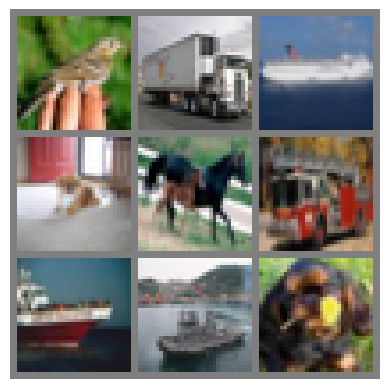

In [3]:
from torch.utils.data import DataLoader
from torchvision import utils
import numpy as np
# Функция для визуализации изображений
def imshow(img):
    img = img / 2 + 0.5  # денормализация к диапазону [0, 1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


dataiter = iter(dataloader_train)
images, labels = next(dataiter)
imshow(utils.make_grid(images[:9], nrow=3))


# GAN

In [4]:

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, img_size=32):
        super().__init__()
        self.img_size = img_size
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_channels * img_size * img_size),
            nn.Tanh(),  # выход в диапазоне [-1, 1]
        )

    def forward(self, x):
        return self.gen(x).view(-1, 3, self.img_size, self.img_size)


class Discriminator(nn.Module):
    def __init__(self, img_channels=3, img_size=32):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_channels * img_size * img_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),  # выход 0..1 (вероятность подлинности)
        )

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        return self.disc(x)


# Создаём экземпляры сети
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

# Функция потерь и оптимизаторы
criterion = nn.BCELoss()  # бинарная кроссэнтропия
lr = 0.0002
opt_gen = optim.Adam(gen.parameters(), lr=lr)
opt_disc = optim.Adam(disc.parameters(), lr=lr)

print('done!')


done!


## Обучение GAN

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Функция для обучения GAN
def train_gan(gen, disc, dataloader_train, num_epochs, z_dim, device):
    # Функция потерь и оптимизаторы
    criterion = nn.BCELoss()  # бинарная кроссэнтропия
    lr = 0.0002
    opt_gen = optim.Adam(gen.parameters(), lr=lr)
    opt_disc = optim.Adam(disc.parameters(), lr=lr)

    # Списки для хранения потерь
    discriminator_losses = []  # Потери дискриминатора
    generator_losses = []  # Потери генератора

    # Обучение
    for epoch in range(num_epochs):
        for batch_idx, (real, _) in enumerate(dataloader_train):
            real = real.to(device)
            batch_size_curr = real.shape[0]

            # ============ Тренируем дискриминатор ============
            # Шум -> фейковые картинки
            noise = torch.randn(batch_size_curr, z_dim).to(device)
            fake = gen(noise)

            # Вычисляем вероятность для реальных и фейковых
            disc_real = disc(real).view(-1)
            disc_fake = disc(fake.detach()).view(-1)

            # Метки (1 - настоящие, 0 - фейк)
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2

            disc.zero_grad()
            lossD.backward()
            opt_disc.step()

            # ============ Тренируем генератор ============
            # Новые фейковые картинки, оцениваем дискриминатором
            output = disc(fake).view(-1)
            lossG = criterion(output, torch.ones_like(output))  # хотим, чтобы дискрим. сказал 1

            gen.zero_grad()
            lossG.backward()
            opt_gen.step()

            # Сохраняем потери
            discriminator_losses.append(lossD.item())
            generator_losses.append(lossG.item())

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

    return discriminator_losses, generator_losses


# Создаём экземпляры сети
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

# Запуск обучения
discriminator_losses, generator_losses = train_gan(gen, disc, dataloader_train, num_epochs, z_dim, device)

Epoch [1/50] | Loss D: 0.0702, Loss G: 9.4838
Epoch [2/50] | Loss D: 0.0562, Loss G: 4.6886
Epoch [3/50] | Loss D: 0.1854, Loss G: 2.6022
Epoch [4/50] | Loss D: 0.4103, Loss G: 5.3756
Epoch [5/50] | Loss D: 0.1150, Loss G: 3.7347
Epoch [6/50] | Loss D: 0.2126, Loss G: 2.9421
Epoch [7/50] | Loss D: 0.5384, Loss G: 3.2996
Epoch [8/50] | Loss D: 0.2628, Loss G: 2.8503
Epoch [9/50] | Loss D: 0.1976, Loss G: 2.7705
Epoch [10/50] | Loss D: 0.2837, Loss G: 2.9915
Epoch [11/50] | Loss D: 0.2648, Loss G: 2.7930
Epoch [12/50] | Loss D: 0.3266, Loss G: 2.1496
Epoch [13/50] | Loss D: 0.2706, Loss G: 2.9134
Epoch [14/50] | Loss D: 0.1862, Loss G: 2.7176
Epoch [15/50] | Loss D: 0.4022, Loss G: 1.8900
Epoch [16/50] | Loss D: 0.3836, Loss G: 2.0954
Epoch [17/50] | Loss D: 0.5474, Loss G: 1.6339
Epoch [18/50] | Loss D: 0.4934, Loss G: 2.4137
Epoch [19/50] | Loss D: 0.3930, Loss G: 2.4061
Epoch [20/50] | Loss D: 0.4790, Loss G: 1.4738
Epoch [21/50] | Loss D: 0.5255, Loss G: 1.9659
Epoch [22/50] | Loss D

# Метрики GAN

## Визуализируем данные

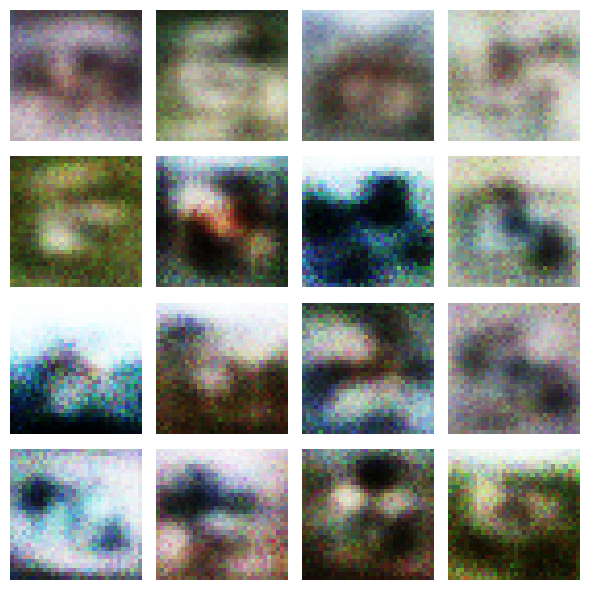

In [7]:

# Проверка генерации: берём шум и смотрим, что получится
gen.eval()
with torch.no_grad():
    sample_noise = torch.randn(16, z_dim).to(device)
    generated = gen(sample_noise).cpu()
    generated = (generated + 1) / 2  # денормализация из [-1,1] в [0,1]

# Отобразим 16 сгенерированных изображений
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated[i].permute(1, 2, 0))  # Перестановка осей для отображения
    ax.axis('off')
plt.tight_layout()
plt.show()

## Отобразим графики потерь

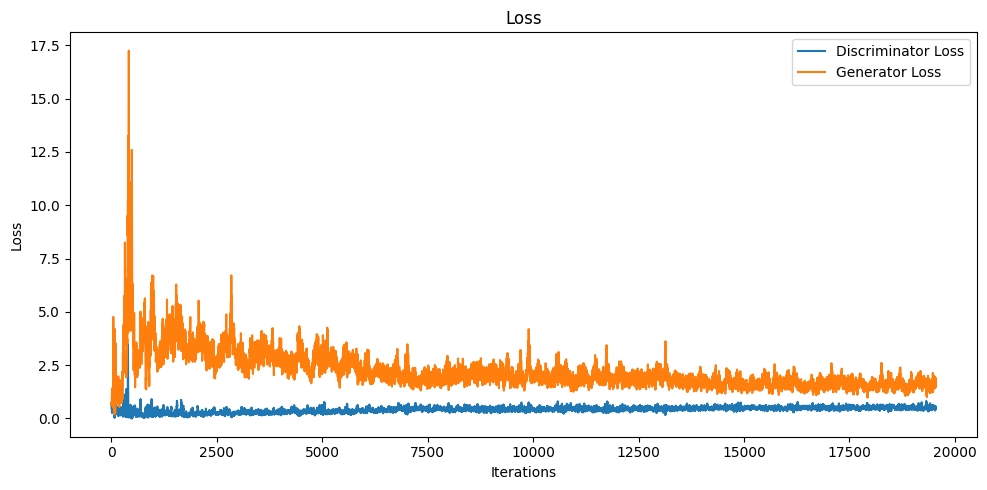

In [8]:
# Функция для построения графиков потерьplot_losses(discriminator_losses, generator_losses):
plt.figure(figsize=(10, 5))
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.title('Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


# DCGAN

In [10]:
!pip install torch-fidelity
clear_output()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

NameError: name 'clear_output' is not defined

In [20]:


# Устройство (GPU при наличии)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Параметры
batch_size = 64
z_dim = 50  # Размерность вектора шума
num_epochs = 10  # Количество эпох
nc = 3  # Количество каналов в изображении (RGB)
ndf = 64  # Количество фильтров в дискриминаторе
ngf = 64  # Количество фильтров в генераторе
lr = 0.0002  # Скорость обучения
beta1 = 0.5  # Параметр для оптимизатора Adam

# Загрузка набора данных CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация в диапазон [-1, 1]
])

train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)




Using device: cuda
Files already downloaded and verified


In [10]:
# Определение генератора
class Generator_DCGAN(nn.Module):
    def __init__(self, ngpu=1):
        super(Generator_DCGAN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 32 x 32``
        )

    def forward(self, input):
        return self.main(input)



# Определение дискриминатора
class Discriminator_DCGAN(nn.Module):
    def __init__(self, ngpu=1):
        super(Discriminator_DCGAN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 32 x 32``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 16 x 16``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 8 x 8``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 4 x 4``
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


Epoch [1/10] | Loss D: 0.2216, Loss G: 2.7547
Epoch [2/10] | Loss D: 0.2951, Loss G: 4.1612
Epoch [3/10] | Loss D: 0.2137, Loss G: 2.8374
Epoch [4/10] | Loss D: 0.0776, Loss G: 3.9718
Epoch [5/10] | Loss D: 0.0750, Loss G: 3.2765


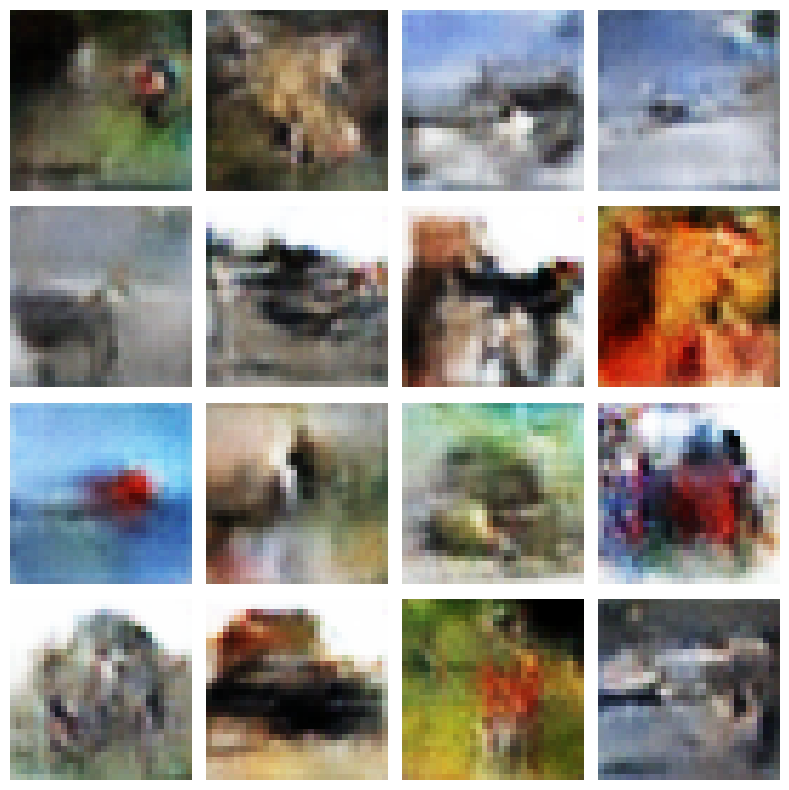

Epoch [6/10] | Loss D: 0.1733, Loss G: 3.4388
Epoch [7/10] | Loss D: 0.3298, Loss G: 8.7524
Epoch [8/10] | Loss D: 0.0168, Loss G: 5.9323
Epoch [9/10] | Loss D: 0.0387, Loss G: 5.1483
Epoch [10/10] | Loss D: 0.3738, Loss G: 7.8196


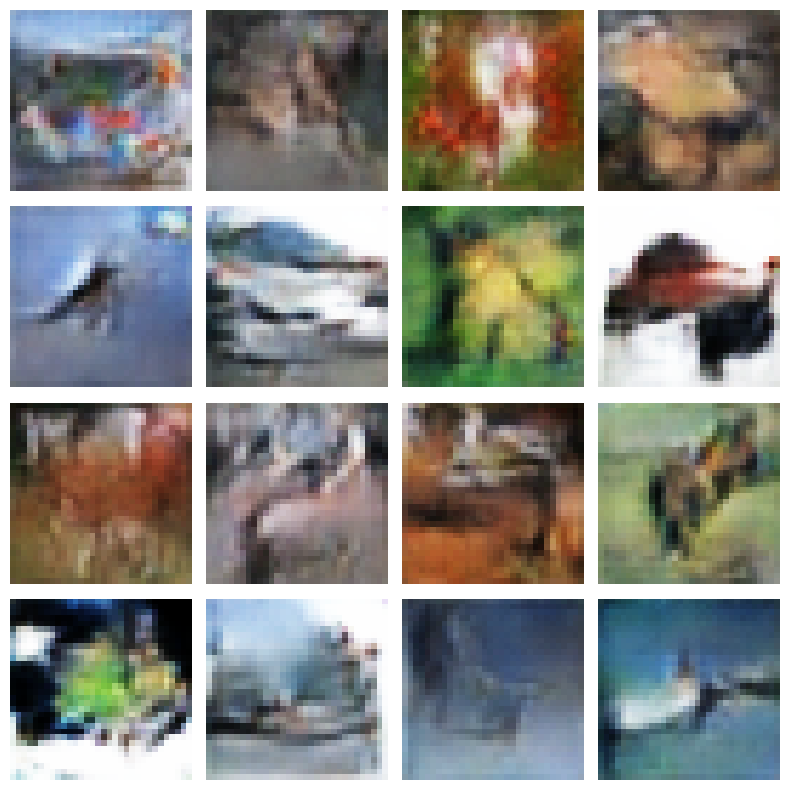

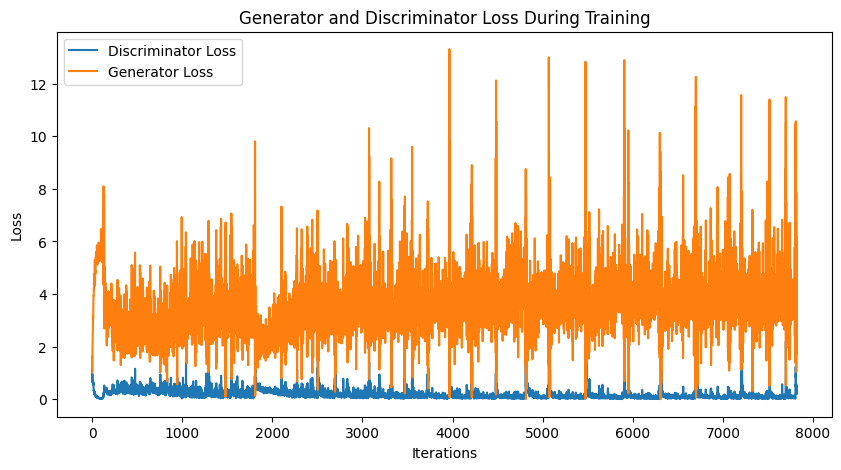

In [21]:
def train(gen, disc, dataloader, num_epochs, device):
    # Функция потерь и оптимизаторы
    criterion = nn.BCELoss()
    opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
    opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))

    # Списки для хранения потерь
    lossD_list = []
    lossG_list = []

    # Обучение
    for epoch in range(num_epochs):
        for batch_idx, (real, _) in enumerate(dataloader):
            real = real.to(device)
            batch_size_curr = real.shape[0]

            # ============ Тренируем дискриминатор ============
            # Шум -> фейковые картинки
            noise = torch.randn(batch_size_curr, z_dim, 1, 1).to(device)
            fake = gen(noise)

            # Вычисляем вероятность для реальных и фейковых
            disc_real = disc(real).view(-1)
            disc_fake = disc(fake.detach()).view(-1)

            # Метки (1 - настоящие, 0 - фейк)
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2

            disc.zero_grad()
            lossD.backward()
            opt_disc.step()

            # ============ Тренируем генератор ============
            # Новые фейковые картинки, оцениваем дискриминатором
            output = disc(fake).view(-1)
            lossG = criterion(output, torch.ones_like(output))  # хотим, чтобы дискрим. сказал 1

            gen.zero_grad()
            lossG.backward()
            opt_gen.step()

            # Сохраняем потери
            lossD_list.append(lossD.item())
            lossG_list.append(lossG.item())

        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}")

        # Визуализация сгенерированных изображений каждые 5 эпох
        if (epoch + 1) % 10 == 0:
            visualize_generated_images(gen, device, z_dim)

    # Построение графиков потерь
    plot_losses(lossD_list, lossG_list, num_epochs)

    return lossD_list, lossG_list

# Функция для визуализации сгенерированных изображений
def visualize_generated_images(gen, device, z_dim):
    with torch.no_grad():
        # Генерация фейковых изображений
        fake_images = gen(torch.randn(16, z_dim, 1, 1).to(device)).cpu()
        fake_images = (fake_images + 1) / 2  # Денормализация
        fake_images = fake_images.permute(0, 2, 3, 1)  # Изменение порядка осей для matplotlib

        # Отображение изображений
        fig, axes = plt.subplots(4, 4, figsize=(8, 8))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(fake_images[i])
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Функция для построения графиков потерь
def plot_losses(lossD_list, lossG_list, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(lossD_list, label="Discriminator Loss")
    plt.plot(lossG_list, label="Generator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Generator and Discriminator Loss During Training")
    plt.legend()
    plt.show()

# Создание моделей
gen = Generator_DCGAN().to(device)
disc = Discriminator_DCGAN().to(device)

# Обучение модели
lossD_list, lossG_list = train(gen, disc, dataloader_train, num_epochs, device)

# Метрики GAN

## Визуализируем данные

## Отобразим графики потерь

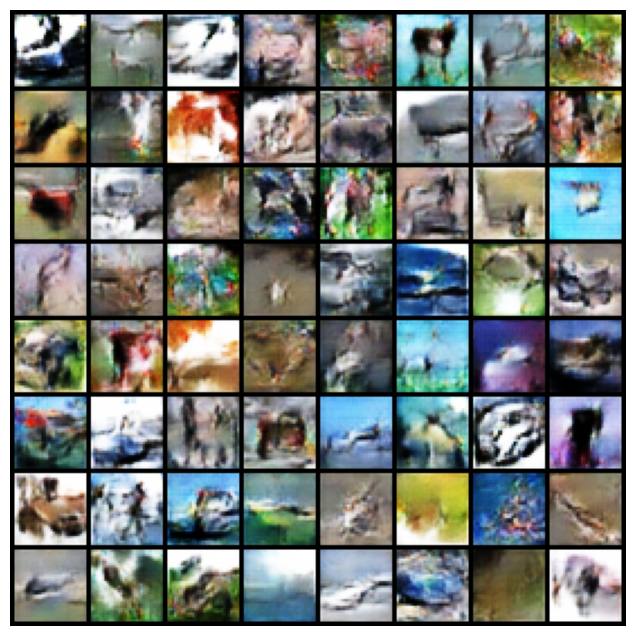

In [22]:
gen.eval()  # Переводим генератор в режим оценки
with torch.no_grad():
    # Генерация шума
    noise = torch.randn(64, z_dim, 1, 1).to(device)  # Создаём шум для 64 изображений
    fake_images = gen(noise).cpu()  # Генерируем изображения и перемещаем их на CPU
    fake_images = (fake_images + 1) / 2  # Денормализация

    # Создание сетки изображений
    grid = torchvision.utils.make_grid(fake_images, padding=2, normalize=True)

    # Визуализация
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(grid, (1, 2, 0)))  # Преобразуем из (C, H, W) в (H, W, C)
    plt.axis("off")  # Отключаем оси
    plt.show()

